In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import os
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool


In [2]:
# Define some constants that we will use
PROJECT_PATH = '/home/ubuntu/projects/kaggle-predict-future-sales'

# Can set this to False to use the memory-intensive set of features
USE_LOW_MEMORY_VERSION = True

TRAIN = 'train'
VALID = 'valid'
TEST = 'test'

In [3]:
# Read in raw CSV files

csv_data = dict()

# Import all csv file data
csv_data[ 'sales_daily' ] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/sales_train.csv') )
csv_data['item_cat'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/item_categories.csv') )
csv_data['item'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/items.csv') )
csv_data['sub'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/sample_submission.csv') )
csv_data['shops'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/shops.csv') )
csv_data['test'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/test.csv') )

In [4]:
# Add some new columns and aggregate from daily to monthly
############################################################

# Add the daily revenue
csv_data['sales_daily'][ "revenue" ] = csv_data['sales_daily'].item_price * csv_data['sales_daily'].item_cnt_day

# Aggregate the monthly data
agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum" }
groupby_cols = [ 'date_block_num', "item_id", "shop_id" ]

# Add the effective item price
csv_data['sales_monthly'] = csv_data['sales_daily'].groupby( groupby_cols ).agg( agg_rules ).reset_index()

# Rename the column to reflect monthly data
csv_data['sales_monthly'].rename( columns={ 'item_cnt_day' : 'item_cnt_month'}, inplace=True )

# Add unit price as a column
csv_data['sales_monthly']['item_price_unit'] = np.round( csv_data['sales_monthly']['revenue'] / \
                              ( 1e-6 + csv_data['sales_monthly']['item_cnt_month'] ) )


In [5]:
# Get all combinations of shops/items for each date
############################################################

df_monthly = csv_data['sales_monthly']

# Only use last 13 months if we are trying to save memory
if USE_LOW_MEMORY_VERSION:
    dates = df_monthly['date_block_num'].unique()[-13:]
else:
    dates = df_monthly['date_block_num'].unique()

# Loop through the dates and append each shop/item combination
df_id = pd.DataFrame( [], columns=['date_block_num', 'shop_id', 'item_id'])
for dt in dates:
    df_t = df_monthly[ df_monthly['date_block_num'] == dt ]
    uniq_shops = df_t['shop_id'].unique()    
    uniq_items = df_t['item_id'].unique()
        
    new_rows = pd.DataFrame( itertools.product( [dt], uniq_shops, uniq_items ), columns=df_id.columns )
    df_id = pd.concat( [ df_id, new_rows ], sort=False, axis=0 )

# Join the test IDs to the data frame
df_t = csv_data['test'].copy()
df_t['date_block_num'] = 1 + df_id['date_block_num'].max()
df_id = pd.concat( [ df_id, df_t ], sort=False, axis=0 ).drop(['ID'], axis=1)

# Create a data frame using all the shop/item pairs from each month
df_sales = df_id.merge( csv_data['sales_monthly'], on=['date_block_num', 'shop_id', 'item_id' ], how='left' )

# Set missing values for revenue and item count to 0
df_sales.loc[ np.isnan(df_sales['revenue']), ['revenue'] ] = 0
df_sales.loc[ np.isnan(df_sales['item_cnt_month']), ['item_cnt_month'] ] = 0

# Make sure values are still NaN for the test period ('date_block_num' == 34)
df_sales.loc[ df_sales['date_block_num'] == 34, 'revenue' ] = np.nan
df_sales.loc[ df_sales['date_block_num'] == 34, 'item_cnt_month' ] = np.nan

In [6]:
# Add new columns to the data frame
############################################################

# Add the category id
df_sales = df_sales.merge( csv_data['item'], on='item_id' )
df_sales = df_sales.drop('item_name', axis=1 )

# Add a column combining shop and item, which together with date_block_num is a unique id
df_sales['shop_item_id'] = df_sales['shop_id'] + 100 * df_sales['item_id']

# Add the month
df_sales['month'] = 1 + (df_sales['date_block_num'] % 12)

# Rename the target column and make it the first column
target = df_sales.loc[:,['item_cnt_month']]
target.columns = [ 'TARGET']
df_sales = pd.concat( [ target, df_sales.drop('item_cnt_month', axis=1) ], axis=1 ) 

# Clip values to be in [0,20]
df_sales['TARGET'] = np.clip( df_sales['TARGET'], 0, 20 )


In [7]:
%%time
# Make time series out of the monthly  sales
pivot_columns = [ 'shop_id', 'item_id']
target_col = 'item_cnt_month'
grp_table = csv_data['sales_monthly'].groupby( [ 'date_block_num' ] + pivot_columns ).agg( { target_col : 'sum' } ).reset_index()
ts_sales_raw = grp_table.pivot_table( target_col, index="date_block_num", columns=pivot_columns )

# Clip all values to be in [0,20]
ts_sales_raw = np.clip( ts_sales_raw, 0, 20 )

# Make sure the dates are sorted
ts_sales_raw.sort_index(axis=0, ascending=True, inplace=True )

# Create a version that has missing values filled with 0
ts_sales = ts_sales_raw.fillna(0)

# Downcast both versions
ts_sales_raw = ts_sales_raw.astype('float32')
ts_sales = ts_sales.astype('float32')

CPU times: user 5.26 s, sys: 485 ms, total: 5.74 s
Wall time: 5.46 s


In [8]:
%%time
# Initialize a list to store features. We will concatenate these afterwards with hstack
feature_vals = []
feature_names = []

# Just keep the last M months of observations, and convert to a numpy column vector
process_features = lambda x : x.to_numpy().ravel()[:,np.newaxis]

# Add the 'date_block_num' as a feature
ts_dates = np.tile( np.array(ts_sales.index)[:,np.newaxis], ts_sales.shape[1] )
feature_vals.append( process_features(pd.DataFrame(ts_dates) ) )
feature_names.append( 'date_block_num' )

# Add 'shop_item_id' as a feature
for j, col in enumerate(ts_sales.columns.names):
    ts = np.array([ x[j] for x in ts_sales.columns ] * ts_sales.shape[0]).reshape( ts_sales.shape[0], ts_sales.shape[1])
    feature_vals.append( process_features(pd.DataFrame(ts) ) )  
    feature_names.append( col )
    
if USE_LOW_MEMORY_VERSION:
    # Add 1-month lagged sales
    ts = ts_sales.copy()
    feature_vals.append( process_features(ts) )
    feature_names.append( 'sales_lag_01' )
    
    # Add 6-month mean rolling sales
    ts = ts_sales.rolling(window=6).mean()
    feature_vals.append( process_features(ts) )    
    feature_names.append( 'sales_mean_06' )
    
    # Add 12-month mean rolling sales
    ts = ts_sales.rolling(window=12).mean()
    feature_vals.append( process_features(ts) )    
    feature_names.append( 'sales_mean_12' )    
else:
    # Get lagged monthly sales
    print( 'Calculating lagged sales...')
    lags = np.arange(1,13)
    for L in lags:
        ts = ts_sales.shift(periods=L-1)
        feature_vals.append( process_features(ts) )
        feature_names.append( 'sales_lag_{:02}'.format(L) )

    # Get lagged monthly mean sales
    print( 'Calculating rolling mean sales...')
    means = [3, 6, 9, 12]
    for M in means:
        ts = ts_sales.rolling(window=M).mean()
        feature_vals.append( process_features(ts) )    
        feature_names.append( 'sales_mean_{:02}'.format(M) )

    # Get 12-month standard deviation
    print( 'Calculating std. dev. of sales...')
    means = [6, 12]
    for M in means:
        ts = ts_sales.rolling(window=M).std()
        feature_vals.append( process_features(ts) )
        feature_names.append( 'sales_std_{:02}'.format(M) )

    # Get the 12-month quartiles
    print( 'Calculating quantiles of sales...')
    for p in [ 0.25, 0.50, 0.75]:
        ts = ts_sales.rolling(window=12).quantile(p)
        feature_vals.append( process_features(ts) )    
        feature_names.append( 'sales_percentile_{:02}_12'.format(int(p * 100) ) )

CPU times: user 10.6 s, sys: 826 ms, total: 11.4 s
Wall time: 11.4 s


In [9]:
# Downcast floats and ints to 32-bit to save memory
################################################################

def downcast_dataframe( df ):
    for col in df.columns:
        if isinstance( df[col ].iloc[0], np.float64 ) or isinstance( df[col ].iloc[0], float ):
            df[col] = df[col].astype('float32')
        elif isinstance( df[col ].iloc[0], np.int64 ) or isinstance( df[col ].iloc[0], int ):
            df[col] = df[col].astype('int32')
            
    return df


In [10]:
def get_months_since_first_and_last_observation( input_ts ):
    """Gets the number of months since the first and last observation in each columns, 
    at each point in time. This function has no 'look-forward' bias."""
    
    # Create an array with the index (0 to T) of any non-zeros entries
    month_of_obs = input_ts.to_numpy() * np.arange(1,input_ts.shape[0]+1)[:,np.newaxis]
    month_of_obs = month_of_obs.astype('float32')
    month_of_obs[ np.less( month_of_obs, 0.1, where=~np.isnan(month_of_obs)) ] = np.nan

    # Make a data frame
    df_month_of_obs = pd.DataFrame( month_of_obs, columns=input_ts.columns)

    # Loop through the time steps and find the months since first/last action at each t
    months_since_first_obs = np.nan * np.ones_like(month_of_obs)
    months_since_last_obs = np.nan * np.ones_like(month_of_obs)
    for t in range( month_of_obs.shape[0] ):
        months_since_first_obs[t,:] = t - df_month_of_obs.iloc[:(t+1),:].idxmin(axis=0)
        months_since_last_obs[t,:] = t - df_month_of_obs.iloc[:(t+1),:].idxmax(axis=0)    

    # Fill NaN's with 999 for shop/items that have never seen a sale
    months_since_first_obs[ np.isnan( months_since_first_obs ) ] = 999
    months_since_last_obs[ np.isnan( months_since_last_obs ) ] = 999

    # Convert back into pandas Dataframe
    months_since_first_obs = pd.DataFrame( months_since_first_obs, columns=ts_sales.columns )
    months_since_last_obs = pd.DataFrame( months_since_last_obs, columns=ts_sales.columns )
    
    return months_since_first_obs, months_since_last_obs


In [11]:
%%time
# Get the number of months since the first and last sale, at each point in time
months_since_first_sale, months_since_last_sale = \
        get_months_since_first_and_last_observation( ts_sales_raw )

# Add to features
feature_vals.append( process_features( months_since_first_sale.astype('float32') ) )
feature_names.append( 'months_since_first_sale' )
feature_vals.append( process_features( months_since_last_sale.astype('float32') ) )
feature_names.append( 'months_since_last_sale' )

CPU times: user 1min 4s, sys: 989 ms, total: 1min 5s
Wall time: 1min 5s


In [12]:
%%time 
# Join the features into a pandas data frame
features_list = [ x for x in feature_vals ]
df_calc = pd.DataFrame( np.hstack(features_list), columns=feature_names)

# We must shift the date_block_num forward by 1 for the calculated columns, 
#    since these are not available until the next month
df_calc['date_block_num'] = 1 + df_calc['date_block_num'].values


CPU times: user 1.09 s, sys: 436 ms, total: 1.53 s
Wall time: 1.53 s


In [13]:
%%time
# Combine the sales data with the calculated features
df_full = df_sales.merge( df_calc, on=['date_block_num', 'shop_id', 'item_id' ], how='left' )
df_full = downcast_dataframe(df_full)

# Only use the last few periods if we are trying to save memory
if USE_LOW_MEMORY_VERSION:
    df_full = df_full[ df_full['date_block_num'] >= 31 ]
else:
    df_full = df_full[ df_full['date_block_num'] >= 22 ]

# Clean up missing values in the calculated columns
calc_sales_cols = list( df_calc.columns[ [ x.startswith('sales_') for x in df_calc.columns ] ] )
df_full[calc_sales_cols] = df_full[calc_sales_cols].fillna(0)

# Add features for months since first/last sale of a shop/item pair
df_full['months_since_first_sale'] = df_full['months_since_first_sale'].fillna(999).values
df_full['months_since_last_sale'] = df_full['months_since_last_sale'].fillna(999).values

# Add a binary feature that describes whether a shop/item pair is active
df_full['shop_item_never_active'] = ( df_full['months_since_first_sale'] == 999 ).astype('int32')
df_full['shop_item_inactive'] = ( df_full['months_since_last_sale'] > 12 ).astype('int32')

# Create a new column representing the total sales over the past 12 months
df_full['sales_total_12'] = 12 * df_full['sales_mean_12']

CPU times: user 11.9 s, sys: 3.67 s, total: 15.6 s
Wall time: 15.6 s


In [14]:
# Add additional grouped features 
#############################################

def create_group_features( df, group_col, agg_rule, target_col, new_col_name=None ):
    if new_col_name is None:
        new_col_name = target_col + '_' + agg_rule + '_by_' + group_col 
        
    vals = df_full.groupby( [ 'date_block_num', group_col ] )[ target_col ].transform(agg_rule)
    df[new_col_name] = vals.astype('float32')    
    return df

In [15]:
%%time

# Add additional categorical features
#############################################

# Create a new column representing the total sales over the past 12 months
df_full['sales_total_12'] = 12 * df_full['sales_mean_12']

for target_col in [ 'sales_lag_01', 'sales_total_12' ]:
    for agg_rule in [ 'sum', 'mean' ]:
        for group_col in [ 'item_id', 'shop_id', 'item_category_id' ]:
            df_full = create_group_features( df_full, group_col, agg_rule, target_col )

for group_col in [ 'item_id', 'shop_id', 'item_category_id']:
    df_full = create_group_features( df_full, group_col, 'min', 'months_since_first_sale', \
                                    new_col_name='min_months_since_first_sale_for_' + group_col.replace('_id', '') )
    df_full = create_group_features( df_full, group_col, 'min', 'months_since_last_sale', \
                                    new_col_name='min_months_since_last_sale_for_' + group_col.replace('_id', '') )
    
    df_full = create_group_features( df_full, group_col, 'mean', 'shop_item_never_active', \
                                    new_col_name=group_col.replace('_id', '') +'_mean_never_active' )
    df_full = create_group_features( df_full, group_col, 'mean', 'shop_item_inactive', \
                                    new_col_name=group_col.replace('_id', '') +'_mean_inactive' )


CPU times: user 1.73 s, sys: 1.61 s, total: 3.34 s
Wall time: 3.34 s


In [16]:
# Define the base set of features that will be used for training and validation
########################################################################

# Drop the revenue and price columns
df_base = df_full.drop( [ 'item_price', 'item_price_unit', 'revenue' ], axis=1 )

# Only keep the past 12 periods for testing
df_base = downcast_dataframe( df_base )

In [17]:
# Save the raw features to a HDF5 file
print( 'File size: {:02} MB'.format( np.round( df_base.memory_usage().sum() / 1e6 ) ) )
#file_name = os.path.join( PROJECT_PATH, 'preprocessed_data/base_features.h5')
#df_base.to_hdf(file_name, key='base_features')     

File size: 145.0 MB


In [18]:
# Read in the raw features from a HDF5 file
# file_name = os.path.join( PROJECT_PATH, 'preprocessed_data/raw_features.h5')
# df_full = pd.read_hdf(file_name, key='raw_features')

In [19]:

def heatMap(corr, figsize=(40,40)):
    #Plot figsize
    fig, ax = plt.subplots(figsize=figsize)
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

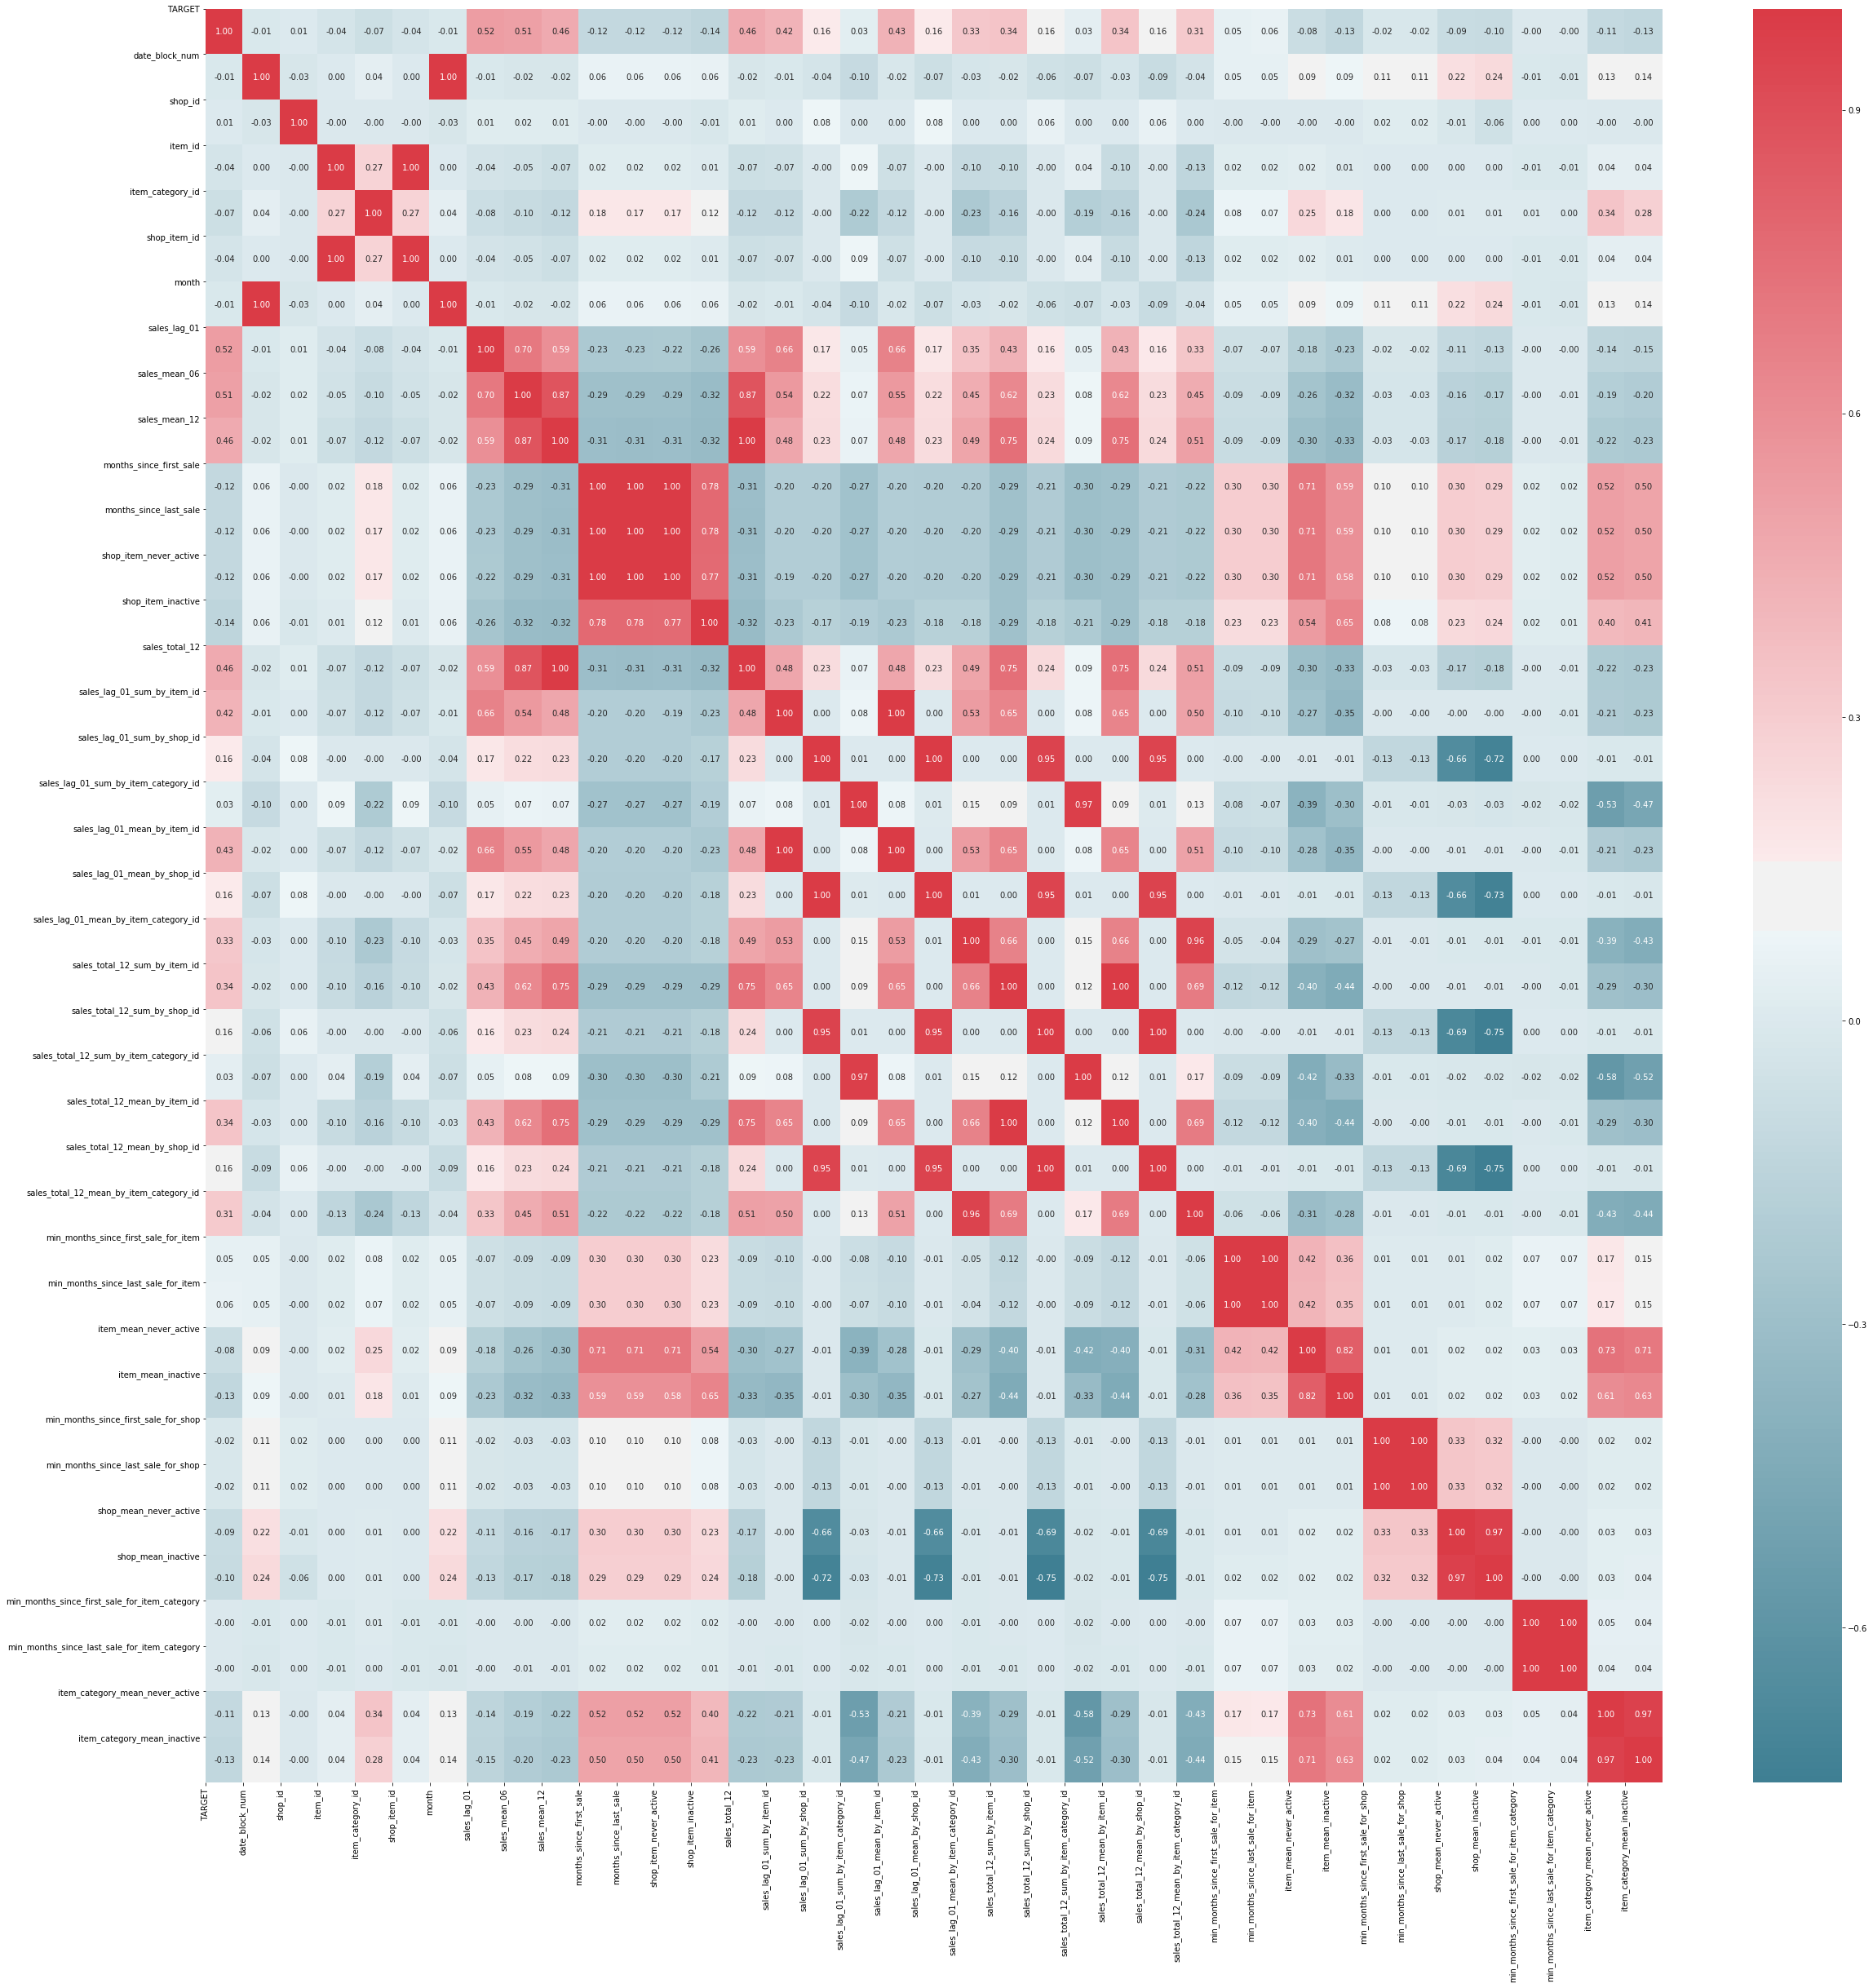

In [20]:
# Find the correlations, excluding rows with NaN values
corr = df_base[np.all( ~np.isnan( df_base ), axis=1)].corr()
heatMap(corr)

In [21]:
# Get different datasets, in chronological order
# The test set is always the next period after the end of the train set.
##########################################################################

def get_validation_set( df, idx, min_train_size ):

    date_blocks = df['date_block_num']
    uniq_date_blocks = np.sort( date_blocks.unique() )

    n_datasets = len(uniq_date_blocks) - min_train_size - 1
    if idx >= 0:
        split_date = uniq_date_blocks[min_train_size + idx]
    else:
        split_date = uniq_date_blocks[idx]    

    xtrain = df[ date_blocks < split_date].drop('TARGET', axis=1 )
    ytrain = df[ date_blocks < split_date ]['TARGET'][:,np.newaxis]
    xtest = df[ date_blocks == split_date ].drop('TARGET', axis=1 )
    ytest = df[ date_blocks == split_date ]['TARGET'][:,np.newaxis]

    return xtrain, ytrain, xtest, ytest


In [22]:
# Construct some train/validation/test data sets
##########################################################################

# Specify which Dataframe to use
features_df = df_base

if USE_LOW_MEMORY_VERSION:
    MIN_TRAIN_SIZE = 2
else:
    MIN_TRAIN_SIZE = 5

data_sets = []
for j in range(100):
    try:
        xtrain, ytrain, xtest, ytest = get_validation_set( features_df, j, min_train_size=MIN_TRAIN_SIZE )
        data_sets.append( ( xtrain, ytrain, xtest, ytest ) )
    except IndexError:
        break

In [23]:
# Define functions for mean encoding
########################################################################

def encode_means_with_cv( X, y, group_col, n_splits ):

    kf = KFold(n_splits=n_splits, shuffle=True)
    split_info = [ x for x in kf.split(X) ]

    if isinstance( y, np.ndarray ):
        # Make sure the target values are a 1-d array
        y = y.ravel()
        
    encoded_feature = pd.Series( np.nan * np.ones_like(y), index = X[group_col] )

    for splt in split_info:
        # Get the test and train indices for the current fold
        idx_train, idx_test = splt

        # Get the test and train data
        X_train = X.iloc[idx_train,:]
        y_train = y[idx_train]
        X_test = X.iloc[idx_test,:]
        y_test = y[idx_test]

        # Put the means into the output vector
        data = ( X_train, y_train, X_test, y_test )
        encoded_feature.iloc[idx_test] = encode_means_from_test_train_split( data, group_col )

    # Fill missing values with the global mean
    encoded_feature = encoded_feature.fillna( np.nanmean( y ) )
    
    return encoded_feature


def encode_means_from_test_train_split( data, group_col):
    
    # expand the input train/test data (we don't ever use the TARGET value from the test set 'y_test')
    X_train, y_train, X_test, _ = data
    
    # Combine the TARGET column and features together
    train_data = pd.concat( [X_train, pd.DataFrame( y_train, index=X_train.index.values, columns=['TARGET'] ) ], axis=1 )
    test_data = X_test
        
    # Get item IDs common to both test and train, and also those just found in the test set
    common_ids = set(test_data[group_col]).intersection( set(train_data[group_col]) )
    missing_ids = set(test_data[group_col]).difference(common_ids)

    # Construct a dictionary mapping item IDs from the test set to their means in the train set
    train_means = train_data.groupby(group_col)['TARGET'].mean()    
    common_means = pd.Series( [ train_means[x] for x in list(common_ids) ], index=pd.Index(common_ids, dtype='int64' ) )
    missing_means = pd.Series( np.nan * np.ones_like(missing_ids), index=pd.Index(list(missing_ids), dtype='int32' ) )
    all_means = dict(pd.concat( [ common_means, missing_means ] ) )

    encoded_features_test = np.array( [ all_means[x] for x in test_data[group_col] ], dtype='float32' )
    
    # Fill missing values with the global mean
    encoded_features_test[ np.isnan(encoded_features_test) ] = np.nanmean( y_train )
    
    return encoded_features_test    


In [24]:
n_splits = 5
group_cols = [ 'item_id', 'shop_id', 'item_category_id', 'shop_item_id', 'date_block_num', 'month', 
             'shop_item_never_active', 'shop_item_inactive']

for j in range(len(data_sets)):
    
    ds_j = data_sets[j]
    X_train, y_train, X_test, y_test = ds_j
    
    for group_col in group_cols:

        new_col_name = 'TARGET' + '_mean_' + group_col
        print('Encoding mean on dataset {} for column {}...'.format(j, new_col_name ) )

        if new_col_name not in X_train:
            X_train[new_col_name] = encode_means_with_cv( X_train, y_train, group_col, n_splits ).to_numpy()

        if new_col_name not in X_test:
            X_test[new_col_name] = encode_means_from_test_train_split( ds_j, group_col=group_col)

    # Update the datasets with the mean encoded column
    data_sets[j] = ( X_train, y_train, X_test, y_test) 

Encoding mean on dataset 0 for column TARGET_mean_item_id...
Encoding mean on dataset 0 for column TARGET_mean_shop_id...
Encoding mean on dataset 0 for column TARGET_mean_item_category_id...
Encoding mean on dataset 0 for column TARGET_mean_shop_item_id...
Encoding mean on dataset 0 for column TARGET_mean_date_block_num...
Encoding mean on dataset 0 for column TARGET_mean_month...
Encoding mean on dataset 0 for column TARGET_mean_shop_item_never_active...
Encoding mean on dataset 0 for column TARGET_mean_shop_item_inactive...
Encoding mean on dataset 1 for column TARGET_mean_item_id...
Encoding mean on dataset 1 for column TARGET_mean_shop_id...
Encoding mean on dataset 1 for column TARGET_mean_item_category_id...
Encoding mean on dataset 1 for column TARGET_mean_shop_item_id...
Encoding mean on dataset 1 for column TARGET_mean_date_block_num...
Encoding mean on dataset 1 for column TARGET_mean_month...
Encoding mean on dataset 1 for column TARGET_mean_shop_item_never_active...
Encodi

In [25]:
%%time

rf = RandomForestRegressor( 
    n_estimators=100, 
    n_jobs=16, 
    criterion='mse', 
    max_depth=15, 
    min_samples_split=5, 
    max_features = 'sqrt'
)

X_train, y_train, X_valid, y_valid = data_sets[0]

# Fit Random Forest 
rf.fit( X_train, y_train.ravel() )

# Predict on the validaiton set
y_hat = rf.predict(X_valid)
print( 'RMSE: {}'.format( np.sqrt( mean_squared_error( y_valid, y_hat ) ) ) )

RMSE: 0.9482840626955801
CPU times: user 2min 21s, sys: 330 ms, total: 2min 21s
Wall time: 9.94 s


1. feature TARGET_mean_item_id (0.197781)
2. feature sales_lag_01 (0.093431)
3. feature TARGET_mean_shop_item_id (0.075010)
4. feature sales_mean_06 (0.057338)
5. feature sales_lag_01_mean_by_item_id (0.052059)
6. feature sales_total_12 (0.047851)
7. feature sales_mean_12 (0.045220)
8. feature sales_lag_01_sum_by_item_id (0.040626)
9. feature shop_item_id (0.022650)
10. feature TARGET_mean_item_category_id (0.022613)
11. feature sales_total_12_sum_by_item_id (0.021178)
12. feature TARGET_mean_shop_id (0.021154)
13. feature sales_total_12_mean_by_item_id (0.020108)
14. feature sales_lag_01_mean_by_item_category_id (0.018709)
15. feature shop_mean_never_active (0.016152)
16. feature shop_mean_inactive (0.016119)
17. feature item_id (0.015159)
18. feature item_category_mean_inactive (0.015101)
19. feature sales_lag_01_sum_by_shop_id (0.014926)
20. feature sales_lag_01_mean_by_shop_id (0.014586)
21. feature sales_total_12_mean_by_item_category_id (0.014422)
22. feature sales_total_12_mean_

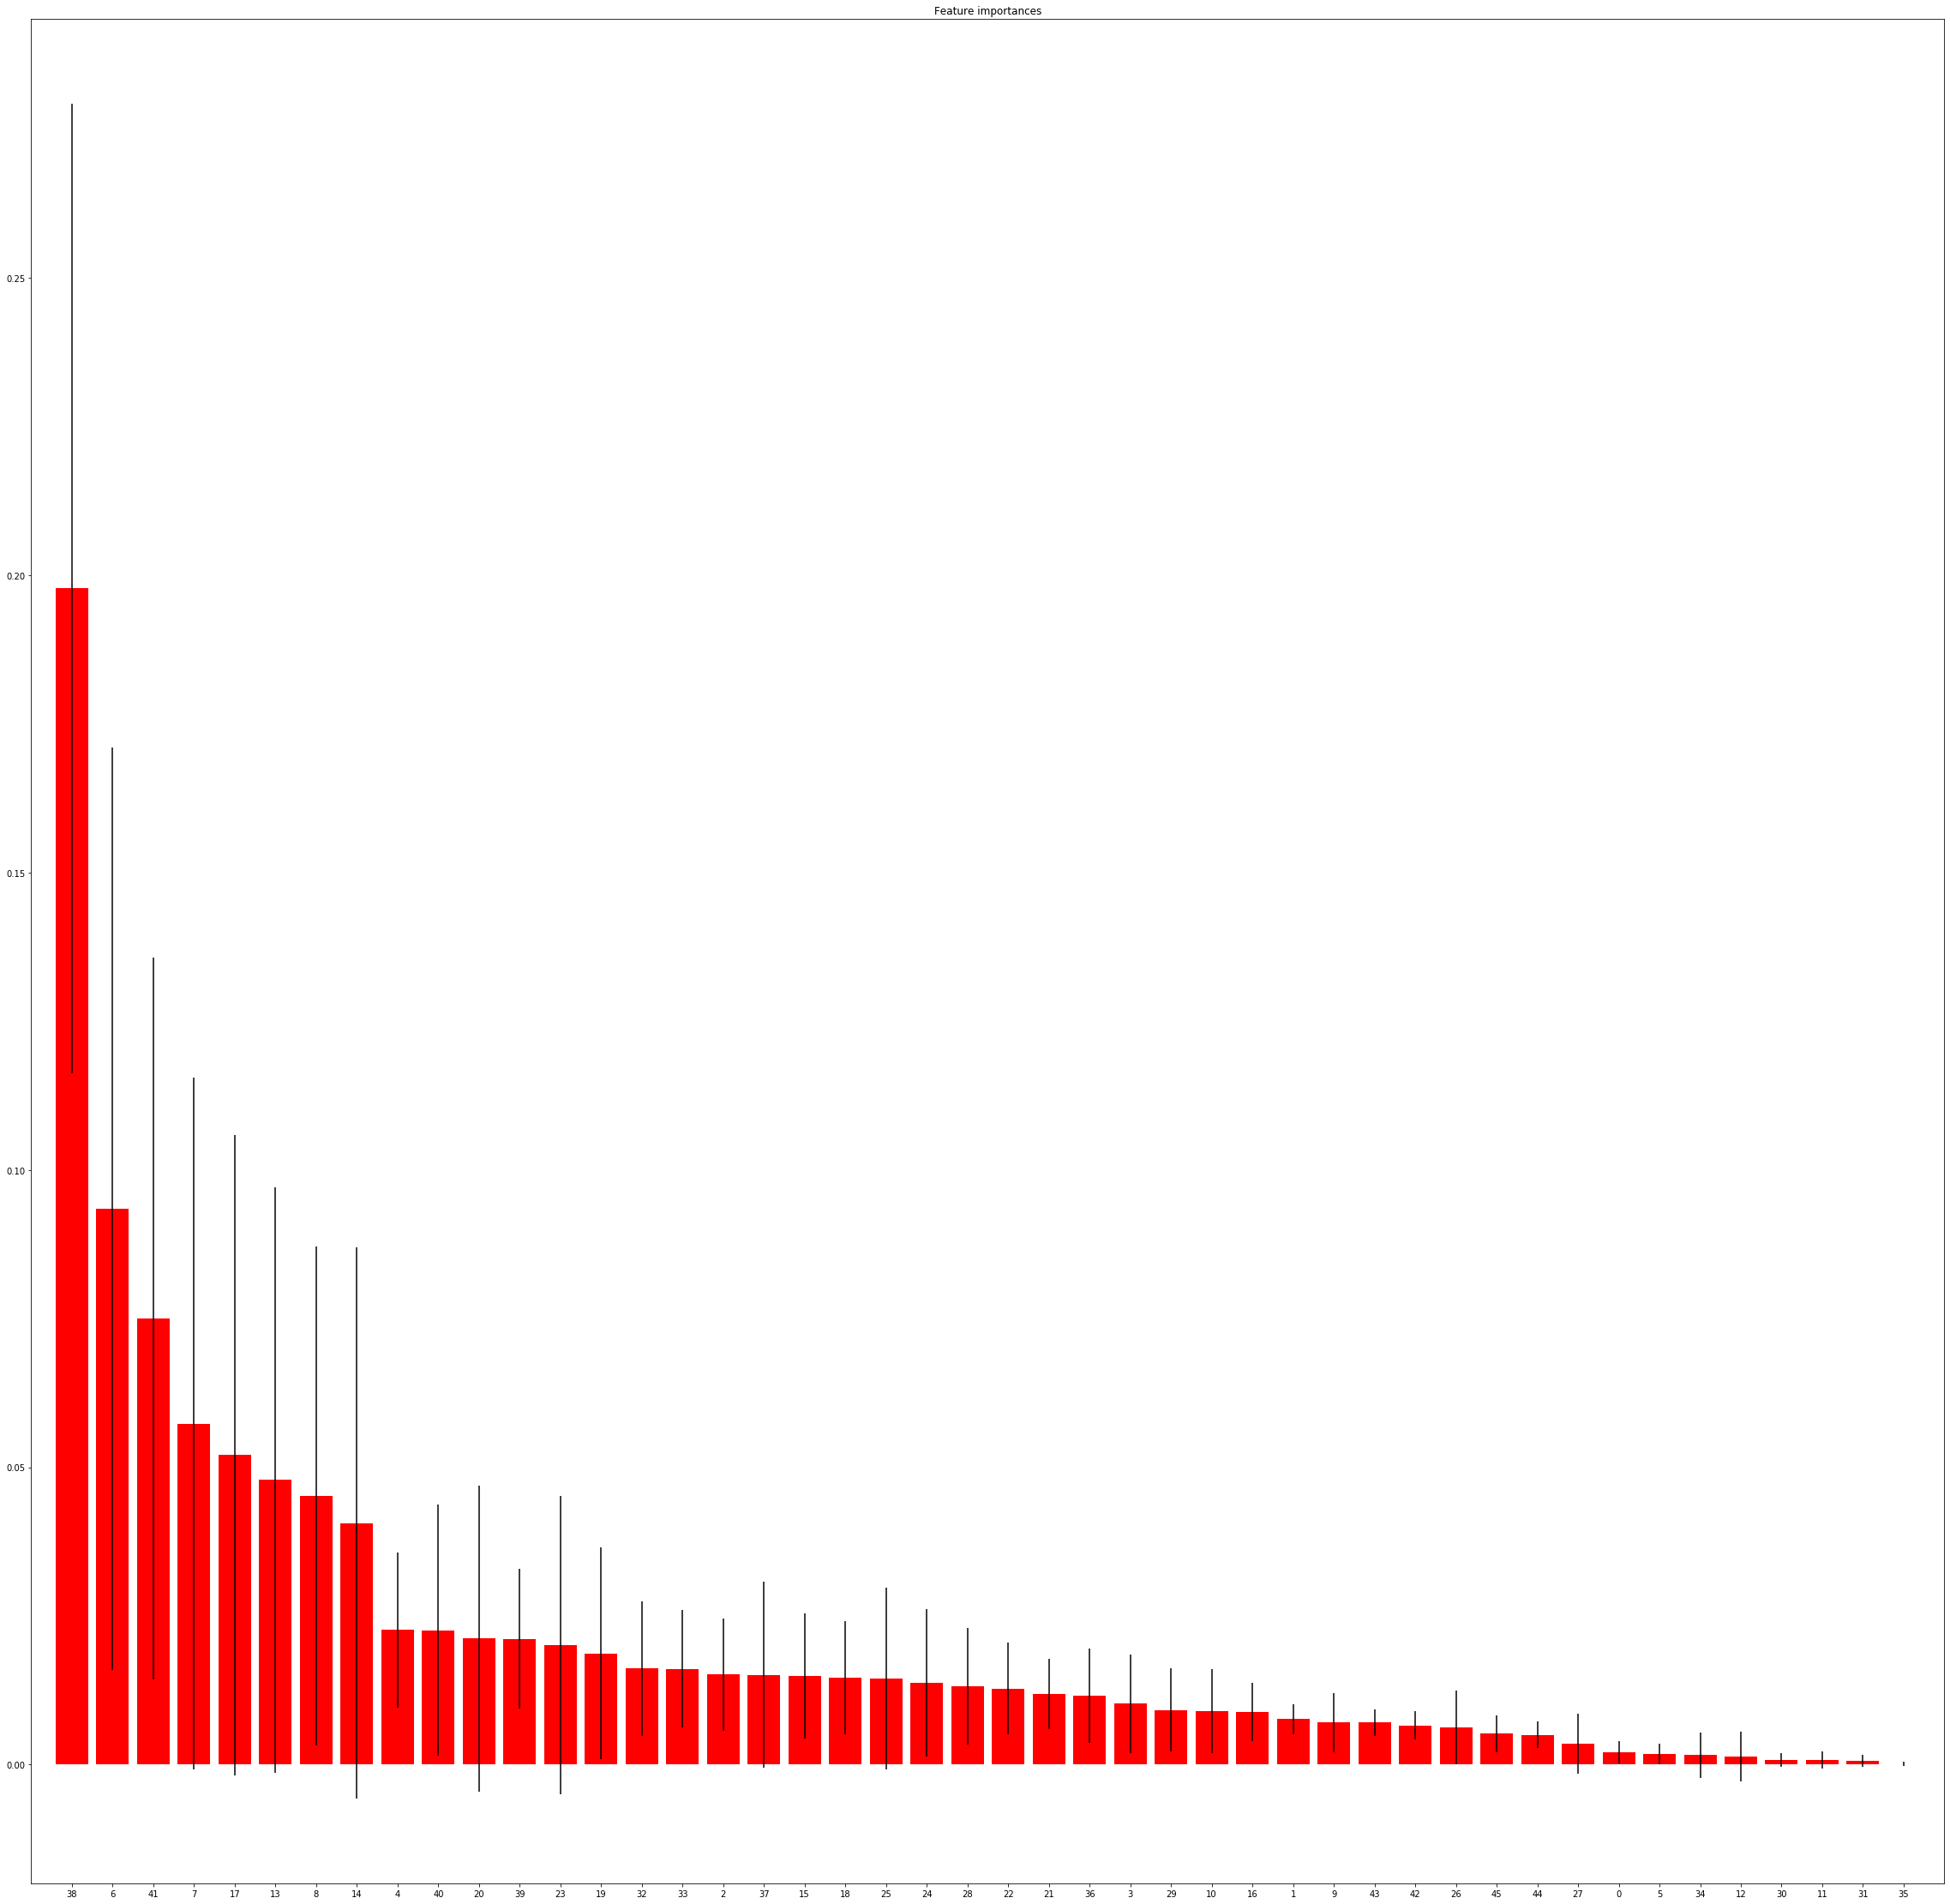

In [26]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(40,40))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [207]:
def get_forecast_as_df( yhat, X_test ):

    if isinstance( yhat, pd.Series ):
        yhat = yhat.to_numpy()

    # Add the shop and item ids to the forecast so we can merge it with the test csv later
    yhat_mtx = np.hstack( [ yhat.reshape(len(yhat),1), X_test[['shop_id', 'item_id']].to_numpy() ] )
    df_fcst = pd.DataFrame( yhat_mtx, columns=['item_cnt_month', 'shop_id', 'item_id'] )
    
    return df_fcst

def write_forecast_to_file( df_fcst, output_file ):    
    
    # Merge the forecast with the test csv
    df_out = df_fcst.merge( csv_data['test'], on=['shop_id', 'item_id'], suffixes=('_fcst', '_test'), how='left' )
    
    # Only include the ID and item_cnt_month columns for the submission csv
    folder = os.path.split( output_file )[0]
    
    if 'test' == os.path.split(folder)[1]:
        df_out = df_out[['ID', 'item_cnt_month']]
    else:
        df_out = df_out[['shop_id', 'item_id', 'item_cnt_month']]
    
    # Write the combined csv to file
    write_to_file( output_file, df_out )
    
        
def write_to_file( output_file, df ):
    
    folder_path = os.path.split( output_file )[0]
    subfolder_path = os.path.split( folder_path )[0]
    
    # Create folder to store results, if it is missing
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    # Create folder for the validation set if it is missing
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
            
    # Write the dataframe to csv
    df.to_csv( output_file, index=False )
    

def get_results_directory():

    if USE_LOW_MEMORY_VERSION:
        results_dir = 'results_small'
    else:
        results_dir = 'results_big'
        
    return results_dir

def get_results_subdirectory( data_sets, idx=None, level=0 ):
    
    if level == 0:
        if len(data_sets) == 1 + idx:
            output_folder = 'test'
        else:
            output_folder = 'validation_{}'.format(idx)
    else:
        output_folder = 'ensemble_{}'.format(level)

    results_dir = get_results_directory()
    folder_path = os.path.join( PROJECT_PATH, results_dir, output_folder )
    return folder_path


def get_results_file_name(model_name, data_sets, idx=None, level=0 ):
   
    folder_path = get_results_subdirectory( data_sets, idx=idx, level=level )
    output_file = os.path.join( folder_path, model_name + '.csv' )
            
    return output_file


def get_results_for_model( model_name, data_sets ):

    rmse = []
    for j in range(len(data_sets)):

        file_name = get_results_file_name(model_name, data_sets, idx=j )

        y_hat = pd.read_csv( file_name, index=False)
        y_test = data_sets[j][-1]
        
        # Calculate the RMSE
        if idx == len(data_sets) - 1:
            rmse.append( np.nan )
        else:
            rmse.append( calc_rmse( y_hat, y_test ) )

    return rmse


def calc_rmse( y_hat, y_test ):
    
    rmse = np.sqrt( mean_squared_error( y_hat, y_test ) )
    return rmse

In [28]:

def fit_model( base_model_constructor, model_name, data_sets ):

    fitted_models = []
    for idx in range(len(data_sets)):

        model = base_model_constructor()
        X_train_full, y_train, X_test_full, y_test = data_sets[idx]

        X_train = X_train_full
        X_test = X_test_full
        
        # Fit the model on the train data and make a prediction on the test set
        model.fit( X_train, y_train )
        y_hat = model.predict(X_test)

        # Calculate the RMSE
        if idx == len(data_sets) - 1:
            rmse = np.nan
        else:
            rmse = calc_rmse( y_hat, y_test )
            
        print( 'Writing results for data set {}. RMSE is {}'.format(idx, rmse ) )

        # Write the output to file
        output_file = get_results_file_name(model_name, data_sets, idx=idx )
        
        df_fcst = get_forecast_as_df( y_hat, X_test )
        write_forecast_to_file( df_fcst, output_file )

        fitted_models.append(model)
        
    return fitted_models

In [139]:

class Forecast():
    
    def __init__(self, features=None, preprocess_type='none', params={} ):

        if isinstance( features, str ):
            self.features = [ features ]
        else:
            self.features = features
        
        self.preprocess_type = preprocess_type
        
        # Set the parameters
        if 'params' in params:
            self.params = params['params']
        else:
            self.params = params
     
    
    def fit( self, X, y ):
        
        # Pre-process the features
        X_pp = self._preprocess(X, action='fit' )
        
        # Fit the model using the pre-processed features
        self._model_fit(X_pp, y)
        
    
    def predict( self, X ):
        
        # Pre-process the features
        X_pp = self._preprocess( X, action='predict' )
        
        # Make the prediction using the model and the pre-processed features
        y_hat = self._model_predict(X_pp)        
        
        # Perform any post-processing
        y_hat = self._postprocess( y_hat )
        
        # Clip the forecast to be in [0,20]
        y_hat = np.clip( y_hat, 0, 20 )
        
        return y_hat

    def score( self, X, y ):
        
        y_hat = self.predict(X)
        return np.sqrt( mean_squared_error( y_hat, y ) )

    
    def _model_fit(self, X_pp, y):
        """Fit the model on the pre-processed data"""
        
        self.model.fit(X_pp, y.ravel() )
        
        
    def _model_predict(self, X_pp):
        """Make the prediction using the model and the pre-processed features"""

        y_hat = self.model.predict( X_pp )
        return y_hat
        
    def _preprocess( self, X, action ):

        if self.preprocess_type == 'none':
            X_pp = self._preprocess_none(X, action)
        elif self.preprocess_type == 'nmf':
            X_pp = self._preprocess_nmf(X, action)
        elif self.preprocess_type == 'pca':
            X_pp = self._preprocess_pca(X, action)
        else:
            raise ValueError( "Unknown preprocess_type: {}".format(self.preprocess_type ) )
            
        return X_pp
            
        
    def _preprocess_none(self, X, action):
        
        if self.features is not None:
            return X[self.features]
        else:
            return X
    
    def _preprocess_nmf( self, X, action ):
        
        # Floor the values at 0, as NMF assumes all values are non-negative
        X = np.maximum( 0, X )
        X /= ( X.std(axis=0) + 1e-6)
        
        if action == 'fit':
            N = int(np.round(np.sqrt(X.shape[1])))
            self.nm = NMF( n_components=N) 
            self.nm.fit(X)

        X_pp = self.nm.transform(X)
        
        return X_pp    

    def _preprocess_pca( self, X, action ):
        
        # Normalize the input
        X = (X - X.mean(axis=0) ) / ( X.std(axis=0) + 1e-6)

        if action == 'fit':
            N = int(np.round(np.sqrt(X.shape[1])))                   
            self.pc = PCA( n_components=N)
            self.pc.fit(X)            

        X_pp = self.pc.transform(X)
        
        return X_pp 
    
    def _postprocess( self, yhat ):
        """Do any necessary post-processing before returning the final forecast."""
        
        yhat_pp = yhat
        return yhat_pp 


class _BenchmarkModel():
    
    def __init__(*args, **kwargs):
        pass
    
    def fit(self, X, y ):
        pass
    
    def predict(self, X ):
        # Assume sales stay the same as the previous period's value
        return X.to_numpy()
    
    
class Benchmark(Forecast):

    def __init__(self, features=['sales_lag_01'], preprocess_type='none', **kwargs ):
        
        super(Benchmark, self).__init__( features=features, preprocess_type=preprocess_type, **kwargs )
        
        self.model = _BenchmarkModel(**self.params)
    
    
class LinReg(Forecast):
    
    def __init__(self,features=['sales_lag_01'], preprocess_type='none', **kwargs ):

        super(LinReg, self).__init__( features=features, preprocess_type=preprocess_type, params=kwargs )
        self.model = LinearRegression(**self.params)

    
class RidgeReg(Forecast):
        
    def __init__(self, features=None, preprocess_type='none', **kwargs ):

        super(RidgeReg, self).__init__(features=features, preprocess_type=preprocess_type, **kwargs )

        self.model = Ridge(**self.params)


class LGBM(Forecast):
    
    def __init__(self, features=None, preprocess_type='none', **kwargs ):

        super(LGBM, self).__init__( features=features, preprocess_type=preprocess_type, **kwargs )
        
        # Get the categorical features and number of rounds for boosting from the parameters
        self.model_params = self.params.copy()
        self.cat_features = self.model_params.pop('cat_features', None)
        self.num_boost_round = self.model_params.pop('num_boost_round', None)

        
    def _model_fit(self, X, y ):
        
        lgb_train = lgb.Dataset( X, label=y.ravel(), categorical_feature=self.cat_features )        
        self.model = lgb.train( self.model_params, lgb_train, num_boost_round=self.num_boost_round )
            
            
    def _model_predict(self, X):
        y_hat = self.model.predict( X, num_iteration=self.model.best_iteration)        
        return y_hat


class CatBoost(Forecast):
        
    def __init__(self, features=None, preprocess_type='none', **kwargs ):

        super(CatBoost, self).__init__( features=features, preprocess_type=preprocess_type, **kwargs )
        
        self.model_params = self.params.copy()
        self.cat_features = self.model_params.pop('cat_features', None)
        self.plot = self.model_params.pop('plot', None)
        
        # Construct the model
        self.model = CatBoostRegressor( **self.model_params)

        
    def _model_fit(self, X_pp, y ):

        train_data = Pool( X_pp, y.ravel(), cat_features=self.cat_features )
        
        self.model.fit(
            train_data,
            logging_level='Silent',
            plot=self.plot
        )

    def _model_predict(self, X_pp ):
        
        test_data = Pool( X_pp, cat_features=self.cat_features )
        
        # Check the out-of-sample fit for the validation set
        yhat = self.model.predict(test_data)
        
        return yhat

    
class RF(Forecast):
    
    def __init__(self, features=None, preprocess_type='none', **kwargs ):

        super(RF, self).__init__( features=features, preprocess_type=preprocess_type, **kwargs )
        
        # Construct the model
        self.model = RandomForestRegressor( **self.params)


In [140]:
params = {}
features = ['sales_lag_01']
preprocess_type = 'none'

constr = lambda : Benchmark( features=features, preprocess_type=preprocess_type, params=params )
models = fit_model( constr, 'benchmark', data_sets )

Writing results for data set 0. RMSE is 1.135817050933838
Writing results for data set 1. RMSE is nan


In [141]:
params = {}
features = ['sales_lag_01']
preprocess_type = 'none'

constr = lambda : LinReg( features=features, preprocess_type=preprocess_type, params=params )
models = fit_model( constr, 'linreg_01', data_sets )

Writing results for data set 0. RMSE is 1.009634256362915
Writing results for data set 1. RMSE is nan


In [178]:
params = { 
            'alpha' : 1.24, 
            'normalize' : True
         }

features = None
preprocess_type = 'none'

constr = lambda : RidgeReg( params=params, features=features, preprocess_type=preprocess_type )
models = fit_model( constr, 'ridgereg_01', data_sets )

Writing results for data set 0. RMSE is 0.9755492608718589
Writing results for data set 1. RMSE is nan


In [175]:
# LightGBM parameters
params = {
    'bagging_fraction': 0.80, 
    'boosting_type': 'gbdt', 
    'feature_fraction': 0.18, 
    'lambda': 0.43, 
    'learning_rate': 0.005, 
    'max_depth': 8, 
    'metric': {'rmse'}, 
    'num_boost_round': 270, 
    'num_leaves': 100, 
    'objective': 'regression', 
    'verbose': 0,
    
    # Put additional parameters into the same dictionary,     
    'cat_features' : [ 'shop_id', 'item_id', 'item_category_id',
       'shop_item_id', 'month', 'shop_item_never_active', 'shop_item_inactive']    
}

features = None
preprocess_type = 'none'

constr = lambda : LGBM( params=params, features=features, preprocess_type=preprocess_type )
models = fit_model( constr, 'lightgbm_01', data_sets )

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Writing results for data set 0. RMSE is 0.9461039008092708


/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Writing results for data set 1. RMSE is nan


In [168]:
# Catboost params
params = {
    'boosting_type': 'Plain', 
    'bootstrap_type': 'Bernoulli', 
    'depth': 11, 
    'eval_metric': 'RMSE', 
    'iterations': 80, 
    'l2_leaf_reg': 0.32, 
    'leaf_estimation_method': 'Newton', 
    'learning_rate': 0.018, 
    'max_ctr_complexity': 5, 
    'one_hot_max_size': 2, 
    'random_seed': 63, 
    'random_strength': 3.2, 
    'rsm': 0.56, 
    'subsample': 0.64,
    
    # Put additional parameters into the same dictionary
    'plot': False,     
    'cat_features' : [ 'shop_id', 'item_id', 'item_category_id',
       'shop_item_id', 'month', 'shop_item_never_active', 'shop_item_inactive']    
}


features = None
preprocess_type = 'none'

constr = lambda : CatBoost( params=params, features=features, preprocess_type=preprocess_type )
models = fit_model( constr, 'catboost_01', data_sets )

Writing results for data set 0. RMSE is 0.966055735431577
Writing results for data set 1. RMSE is nan


In [157]:
# Random Forest parameters
params = {
    'criterion': 'mse', 
    'max_depth': 10, 
    'max_features': 0.15,
    'min_samples_split': 20, 
    'n_estimators': 250, 
    'n_jobs': 16
}


features = None
preprocess_type = 'none'

constr = lambda : RF( params=params, features=features, preprocess_type=preprocess_type )
models = fit_model( constr, 'randomforest_01', data_sets )

Writing results for data set 0. RMSE is 0.9417410742830974
Writing results for data set 1. RMSE is nan


In [179]:
def get_all_forecasts(data_sets):
    
    results = []
    for idx in range(len(data_sets)):
        
        res = get_forecasts_single_set( data_sets, idx )
        y_hat = data_sets[idx][-1]
        results.append( (res, y_hat) )
        
    return results

def get_forecasts_single_set( data_sets, idx ):
    
    folder_path = get_results_subdirectory( data_sets, idx=idx )
    files = os.listdir(folder_path)

    results = None
    for f in files:
        file_name = os.path.join( folder_path, f )
        df_file = pd.read_csv( file_name )

        col_name = f.replace( '.csv', '')
        res_df = df_file['item_cnt_month'].to_frame()
        res_df.columns = [ col_name ]

        if results is None:
            results = res_df
        else:
            results = pd.concat( [ results, res_df ], axis=1 )    
    
    return results

In [182]:
# Get all results together
results = get_all_forecasts( data_sets )

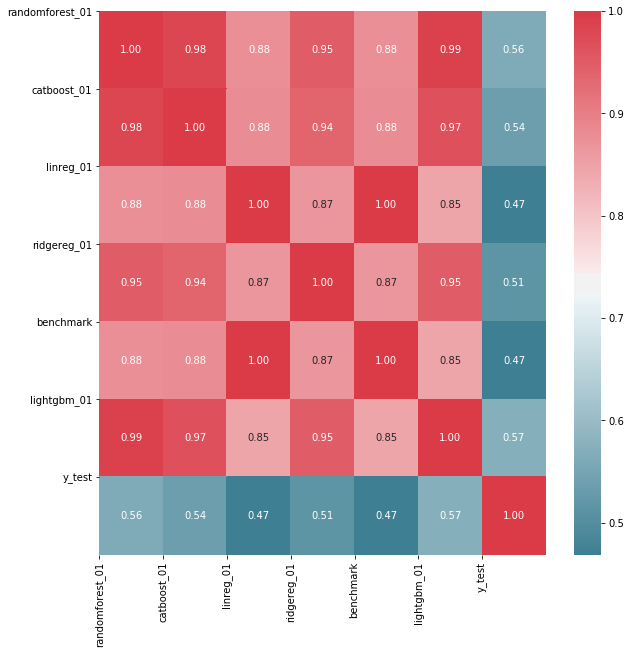

In [183]:
# Check out correlations of different forecasts
out = pd.concat( [ results[0][0], pd.Series( results[0][1].ravel(), name='y_test' ) ], axis=1 )
corr = out.corr()
heatMap( corr, figsize=(10,10) )

In [252]:
# Try to create a forecast that combines all of the individual models
res_train, y_train = results[0]
res_test, y_test = results[1]

# Try taking a linear regression of the individual forecasts
lr = Ridge(alpha=0.15, normalize=True)
lr.fit( res_train, y_train )
print( np.abs( lr.coef_ ).sum() )
y_hat_train = lr.predict(res_train)
y_hat_test = lr.predict(res_test)
print( 'RMSE of ensemble forecast with linear regression: {}'.format( calc_rmse( y_hat_train, y_train ) ) )

# Write the test forecasts to file
output_file = get_results_file_name( model_name, data_sets, idx=1, level=1 )
df_fcst = get_forecast_as_df( y_hat_test, data_sets[1][-2] )
df = csv_data['test'].merge( df_fcst, on=['shop_id', 'item_id'], how='left' )
write_to_file( output_file, df[['ID', 'item_cnt_month']] )

1.1172599590992596
RMSE of ensemble forecast with linear regression: 0.9363779976887813


In [148]:
%%time
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

def optimize_hyperparameters( model_class, ds, param_search_space, int_params=[], max_evals=20 ):

    X_train, y_train, X_valid, y_valid = ds

    def hyperopt_train_test(param_search_space):
        
        model = model_class(params=param_search_space)
        
        model.fit( X_train, y_train )
        
        # Make sure forecasts are in [0,20]
        y_hat = np.clip( model.predict(X_valid), 0, 20 )
        
        # Return the RMSE
        rmse = np.sqrt( mean_squared_error( y_hat, y_valid ) )
        return rmse

    def f(params): 
        for p in int_params:
            params[p] = int( params[p] )

        rmse = hyperopt_train_test(params)
        return {'loss': rmse, 'status': STATUS_OK, 'params' : params}

    trials = Trials()
    best = fmin(f, param_search_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

    # Get the optimal parameters
    losses = np.array( [ x['loss'] for x in trials.results ] )
    opt_params = trials.results[np.argmin(losses)]['params']

    return opt_params, trials

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 16.7 µs


In [176]:
# Ridge Regression
# Hyper parameter search
######################################################

param_search_space = {
    'alpha': hp.loguniform( 'alpha', np.log(0.1), np.log(100) ),
    'normalize': hp.choice( 'normalize', [ True, False ] )
}

model_class = RidgeReg
ds = data_sets[0]
int_params = []
max_evals = 20

opt_params, trials = optimize_hyperparameters( 
                                              model_class=model_class, 
                                              ds=ds, 
                                              param_search_space=param_search_space,
                                              int_params=int_params, 
                                              max_evals=max_evals )

print( opt_params )


 15%|█▌        | 3/20 [00:01<00:08,  2.01it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.52936e-17): result may not be accurate.
  overwrite_a=True).T



 20%|██        | 4/20 [00:01<00:07,  2.04it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.21537e-17): result may not be accurate.
  overwrite_a=True).T



 30%|███       | 6/20 [00:02<00:06,  2.08it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79263e-18): result may not be accurate.
  overwrite_a=True).T



 35%|███▌      | 7/20 [00:03<00:06,  2.09it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.58049e-18): result may not be accurate.
  overwrite_a=True).T



 40%|████      | 8/20 [00:03<00:05,  2.10it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.99072e-19): result may not be accurate.
  overwrite_a=True).T



 45%|████▌     | 9/20 [00:04<00:05,  2.10it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.76026e-17): result may not be accurate.
  overwrite_a=True).T



 50%|█████     | 10/20 [00:04<00:04,  2.10it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.71594e-17): result may not be accurate.
  overwrite_a=True).T



 60%|██████    | 12/20 [00:05<00:03,  2.07it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.82629e-19): result may not be accurate.
  overwrite_a=True).T



 65%|██████▌   | 13/20 [00:06<00:03,  2.08it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.19668e-17): result may not be accurate.
  overwrite_a=True).T



 80%|████████  | 16/20 [00:07<00:01,  2.07it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.85179e-18): result may not be accurate.
  overwrite_a=True).T



 90%|█████████ | 18/20 [00:08<00:00,  2.10it/s, best loss: 0.975541359298225]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.1619e-17): result may not be accurate.
  overwrite_a=True).T



100%|██████████| 20/20 [00:09<00:00,  2.07it/s, best loss: 0.975541359298225]
{'alpha': 1.2413083940158671, 'normalize': True}


/home/ubuntu/projects/.env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82112e-19): result may not be accurate.
  overwrite_a=True).T



In [173]:
# LightGBM
# Hyper parameter search
######################################################

param_search_space = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse' },
    'max_depth' : hp.qloguniform( 'max_depth', np.log(4), np.log(14), 1 ),
    'num_leaves': hp.qloguniform( 'num_leaves', np.log(10), np.log(50000), 1 ),
    'learning_rate': hp.loguniform( 'learning_rate', np.log(0.0001), np.log(0.2) ),
    'feature_fraction': hp.uniform( 'feature_fraction', 0.1, 1), 
    'bagging_fraction': hp.uniform( 'bagging_fraction', 0.1, 1), 
    'lambda' : hp.uniform( 'lambda', 0.1, 2 ), 
    'verbose': 0, 
    
    # Put additional parameters into the same dictionary
    'num_boost_round' : hp.qloguniform( 'num_boost_round', np.log(20), np.log(500), 10 ), 
    'cat_features' : [ 'shop_id', 'item_id', 'item_category_id',
       'shop_item_id', 'month', 'shop_item_never_active', 'shop_item_inactive']        
}

model_class = LGBM
ds = data_sets[0]
int_params = [ 'max_depth', 'num_leaves', 'num_boost_round' ]
max_evals = 20

opt_params, trials = optimize_hyperparameters( 
                                              model_class=model_class, 
                                              ds=ds, 
                                              param_search_space=param_search_space,
                                              int_params=int_params, 
                                              max_evals=max_evals )

print( opt_params )


  5%|▌         | 1/20 [00:03<01:02,  3.26s/it, best loss: 1.0923065746190184]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 10%|█         | 2/20 [00:07<01:05,  3.61s/it, best loss: 1.002298521930119] 

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 15%|█▌        | 3/20 [00:09<00:53,  3.14s/it, best loss: 1.002298521930119]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 20%|██        | 4/20 [00:12<00:50,  3.14s/it, best loss: 0.9981885973501033]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 25%|██▌       | 5/20 [00:17<00:54,  3.64s/it, best loss: 0.987541641420646] 

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 30%|███       | 6/20 [00:21<00:51,  3.68s/it, best loss: 0.987541641420646]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 35%|███▌      | 7/20 [00:27<00:58,  4.53s/it, best loss: 0.987541641420646]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 40%|████      | 8/20 [00:29<00:43,  3.61s/it, best loss: 0.987541641420646]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 45%|████▌     | 9/20 [00:33<00:42,  3.86s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 50%|█████     | 10/20 [00:38<00:40,  4.09s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 55%|█████▌    | 11/20 [00:41<00:34,  3.81s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 60%|██████    | 12/20 [00:43<00:24,  3.11s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 65%|██████▌   | 13/20 [00:48<00:25,  3.65s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 70%|███████   | 14/20 [00:49<00:18,  3.05s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 75%|███████▌  | 15/20 [00:51<00:13,  2.65s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 80%|████████  | 16/20 [00:52<00:09,  2.32s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 85%|████████▌ | 17/20 [00:54<00:06,  2.13s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 90%|█████████ | 18/20 [01:00<00:06,  3.10s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



 95%|█████████▌| 19/20 [01:08<00:04,  4.78s/it, best loss: 0.943350325320364]

/home/ubuntu/projects/.env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



100%|██████████| 20/20 [01:11<00:00,  4.16s/it, best loss: 0.943350325320364]
{'bagging_fraction': 0.8040336349789544, 'boosting_type': 'gbdt', 'cat_features': ('shop_id', 'item_id', 'item_category_id', 'shop_item_id', 'month', 'shop_item_never_active', 'shop_item_inactive'), 'feature_fraction': 0.17550807720523925, 'lambda': 0.4294737634023267, 'learning_rate': 0.0053912893392880105, 'max_depth': 8, 'metric': {'rmse'}, 'num_boost_round': 270, 'num_leaves': 102, 'objective': 'regression', 'verbose': 0}


In [166]:
# CatBoost
# Hyper parameter search
######################################################

param_search_space = {
    'random_seed' : 63,
    'iterations' : hp.qloguniform( 'iterations', np.log(20), np.log(500), 10 ),
    'learning_rate' : hp.loguniform( 'learning_rate', np.log(0.001), np.log(0.2) ),
    'l2_leaf_reg' : hp.loguniform( 'l2_leaf_reg', np.log(0.1), np.log(1000) ),
    'random_strength' : hp.uniform( 'random_strength', 0, 10 ),
    'one_hot_max_size' : hp.choice( 'one_hot_max_size', [1, 2, 4 ] ),
    'leaf_estimation_method' : 'Newton',
    'eval_metric' : 'RMSE',
    'depth' : hp.qloguniform( 'depth', np.log(4), np.log(15), 1 ),
    'boosting_type' : 'Plain',
    'bootstrap_type' : 'Bernoulli',
    'subsample' : hp.uniform( 'subsample', 0.1, 1), 
    'rsm' : hp.uniform( 'rsm', 0.1, 1), 
#    'leaf_estimation_iterations' : 1,
    'max_ctr_complexity' : hp.quniform( 'max_ctr_complexity', 1, 8, 1 ),
    
    
    # Put additional parameters into the same dictionary
    'plot' : False, 
    'cat_features' : [ 'shop_id', 'item_id', 'item_category_id',
       'shop_item_id', 'month', 'shop_item_never_active', 'shop_item_inactive']        
}

model_class = CatBoost
ds = data_sets[0]
int_params = [ 'iterations', 'depth', 'max_ctr_complexity' ]
max_evals = 10

opt_params, trials = optimize_hyperparameters( 
                                              model_class=model_class, 
                                              ds=ds, 
                                              param_search_space=param_search_space,
                                              int_params=int_params, 
                                              max_evals=max_evals )

print( opt_params )

100%|██████████| 10/10 [04:36<00:00, 31.01s/it, best loss: 0.9650568600510641]
{'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'cat_features': ('shop_id', 'item_id', 'item_category_id', 'shop_item_id', 'month', 'shop_item_never_active', 'shop_item_inactive'), 'depth': 11, 'eval_metric': 'RMSE', 'iterations': 80, 'l2_leaf_reg': 0.3215819249767348, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01792281078949899, 'max_ctr_complexity': 5, 'one_hot_max_size': 2, 'plot': False, 'random_seed': 63, 'random_strength': 3.1504964863900797, 'rsm': 0.5627502473510125, 'subsample': 0.6406885208016992}


In [151]:
# Random Forest
# Hyper parameter search
######################################################

param_search_space = {
    'n_jobs' : hp.choice( 'n_jobs', [ 16 ] ),
    'criterion' : hp.choice( 'criterion', [ 'mse' ] ),
    'n_estimators' : hp.choice( 'n_estimators', [50] ), 
    'max_depth' : hp.uniform( 'max_depth', 4, 20 ),
    'min_samples_split' : hp.uniform( 'min_samples_split', 4, 30 ), 
    'max_features' : hp.uniform( 'max_features', 0, 1 )
}

model_class = RF
ds = data_sets[0]
int_params = [ 'n_estimators', 'max_depth', 'min_samples_split' ]
max_evals = 10

opt_params, trials = optimize_hyperparameters( 
                                              model_class=model_class, 
                                              ds=ds, 
                                              param_search_space=param_search_space,
                                              int_params=int_params, 
                                              max_evals=max_evals )

print( opt_params )

100%|██████████| 10/10 [02:28<00:00, 16.92s/it, best loss: 0.9445014077153435]
{'criterion': 'mse', 'max_depth': 10, 'max_features': 0.14409047802273467, 'min_samples_split': 19, 'n_estimators': 50, 'n_jobs': 16}
